<a href="https://colab.research.google.com/github/robin9804/Openholo_Val/blob/master/RS_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **사용 라이브러리**
numpy  
matplotlib  
pandas  
plyfile (for real .ply file)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

!pip install plyfile
import plyfile

# RS method 검증 과정

1) point cloud reading

2) RS propagation -> complex image 추출

3) Encoding - openholo 사용 가능


In [2]:
# parameters
mm = 1e-3
um = 1e-6
nm = 1e-9
wvl_R = 638 * nm  # Red
wvl_G = 520 * nm  # Green
wvl_B = 450 * nm  # Blue

def delta(wvl):
    return wvl * 10  # sampling period

def k0(wvl):
    return (np.pi * 2) / wvl  # wave number

# 픽셀 피치
pp = 4.3 * um  # pixel to pixel parameter

# scale factor
xy_scale = 0.01
z_scale = 0.01
depth_offset = 0.3

# resolution setting
h = 1080 #3840 
w = 1920 #2160

# PLY 파일 구성

ply  
format ascii 1.0  
comment Point Cloud Data Format in OpenHolo Library v1.0  
element color 1  
property int channel  
element vertex 7493  
property float x  
property float y  
property float z  
property uchar red  
property uchar green  
property uchar blue  
property double phase  
end_header


1번 항목이 꼭지점(Vertex), 7493개 꼭지점. x, y, z, Red, Green, Blue, phase로 구성되어있음


In [3]:
# read PLY file and convert to numpy array
with open('drive/My Drive/Colab Notebooks/data/dice_100000.ply', 'rb') as f:
    plydata = plyfile.PlyData.read(f)
data = np.array(plydata.elements[1].data)

[0.314987 0.315613]


(-1.0, 1.0)

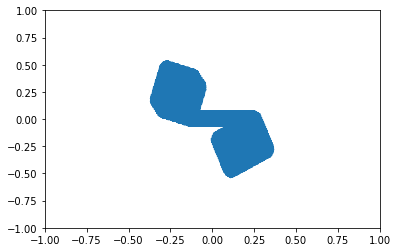

In [4]:
# PLY data 검증
#np.exp(1j*data['phase'][0])
#plydata.elements[0]
print(data['z'][2 : 4])
plt.plot(data['x'],data['y'])
plt.xlim([-1, 1])
plt.ylim([-1,1])

# R-S diffraction with Anti-alliasing

x, y 범위를 x0 - abs(tx / sqrt(1-tx**2)) < x 로 가줘야 한다.

결국 프레넬 회절 공식은 이러한 범위에 의해 zero padding된 형태로 남게 된다.

이때 중요한 것은 pixel과 복원하고자 하는 홀로그램의 크기 등에 따라서 엘리어싱 효과가 달라지는 점이다.


In [5]:
# define R-S method impulse response and Fresnel Integral method
def h_RS(x1, y1, x2, y2, z, wvl):
    """
    RS impulse response
    """
    r = np.sqrt((x1-x2)**2 + (y1-y2)**2 + z**2)
    h = (z / (1j * wvl)) * (np.exp(1j*k0(wvl)*r) / r **2)
    return h

# tx, ty for anti alliasing 
def anti(wvl, z, p):
    """
    anti alliasing condition,
    wvl : wavelength
    z : reconstruction length
    p : pixle pitch
    """
    txy = wvl / (2 * p)
    t = (txy / np.sqrt(1 - txy ** 2)) * z
    return np.abs(t)

# single point로 simulation

점 1개를 진행시켜 간섭패턴을 만들어본다.

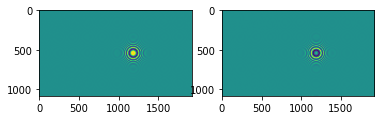

In [69]:
# 최종적으로 생성되는 홀로그램의 크기를 결정하기 위해서 x, y, z scale factor가 필요하다.
scale = 1080
pixel_pitch = 4.5 * um
reconst_Z = 0.3
x_scale = 0.01  # 0.03 이면, scaling factor를 곱해주는 과정이 필요하다.

test_real = np.zeros((scale, 1920))
test_imag = np.zeros((scale, 1920))

for i in range(scale):
    for j in range(1920):
        x = (j - 1920/2) * pixel_pitch *2 
        y = (i - scale/2) * pixel_pitch *2
        A = h_RS(0.2 * x_scale,0, x, y, reconst_Z , wvl_R)
        test_real[i, j] = np.real(A)
        test_imag[i, j] = np.imag(A)


plt.subplot(121)
plt.imshow(test_imag)
plt.subplot(122)
plt.imshow(test_real)

# RS method 를 사용한 hologram generation

RS method를 사용하여 홀로그램을 생성한다.

In [102]:
# R-S method
zz = 0.3  # reconstruct distance
phase = data['phase'][0]  # 5.059415

def RS_hologen(z, wvl):
    """
    hologram generation function
    """
    RS_re = np.zeros((h,w))  # hologram plane - real / imaginary part 생성
    RS_im = np.zeros((h,w))
    for n in range(140):
        x1 = data['x'][50*n] * xy_scale  
        y1 = data['y'][50*n] * xy_scale 
        z1 = data['z'][50*n] * z_scale
        a = anti(wvl, z1, pp) *10  # anti aliasing factor
        RS_cash_r = np.zeros((h,w))
        RS_cash_i = np.zeros((h,w))
        for i in range(h):
            for j in range(w):
                x2 = (j - w//2) * pp *2  # pixel location
                y2 = (i - h//2) * pp*2 
                if (x1 -a < x2 < x1 + a) and (y1 - a < y2 < y1 +a):  # anti alliasing 조건
                    cash = h_RS(x1, y1, x2 , y2 , z - z1, wvl_R) * data['red'][50*n]
                    RS_cash_r[i, j] = np.real(cash)
                    RS_cash_i[i, j] = np.imag(cash)
                else:
                    pass
        RS_re = RS_re + RS_cash_r
        RS_im = RS_im + RS_cash_i
        print(n , " th cash done")
    return RS_re, RS_im


0  th cash done
1  th cash done
2  th cash done
3  th cash done
4  th cash done
5  th cash done
6  th cash done
7  th cash done
8  th cash done
9  th cash done
10  th cash done
11  th cash done
12  th cash done
13  th cash done
14  th cash done
15  th cash done
16  th cash done
17  th cash done
18  th cash done
19  th cash done
20  th cash done
21  th cash done
22  th cash done
23  th cash done
24  th cash done
25  th cash done
26  th cash done
27  th cash done
28  th cash done
29  th cash done
30  th cash done
31  th cash done
32  th cash done
33  th cash done
34  th cash done
35  th cash done
36  th cash done
37  th cash done
38  th cash done
39  th cash done
40  th cash done
41  th cash done
42  th cash done
43  th cash done
44  th cash done
45  th cash done
46  th cash done
47  th cash done
48  th cash done
49  th cash done
50  th cash done
51  th cash done
52  th cash done
53  th cash done
54  th cash done
55  th cash done
56  th cash done
57  th cash done
58  th cash done
59  th 

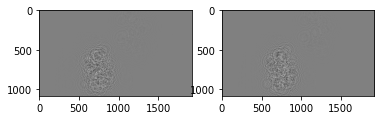

In [103]:
rs_r, rs_i = RS_hologen(zz, wvl_R)

plt.subplot(121)
plt.imshow(rs_r , cmap='gray')

plt.subplot(122)
plt.imshow(rs_i , cmap='gray')

# Reconstruct with fresnel integral
fresnel integral을 활용하여 홀로그램 생성

u(x,y)=zjλ∫∫u(ξ,η)exp(jkr01)r201dξdη≅ejkzjλz∫∫u(ξ,η)exp{jk2z[(x−ξ)2+(y−η)2]}dξdη


In [86]:
def h_Fresnel(x1, y1, z1, x2, y2, z2, wvl):
    """
    Fresnel integral inpulse response
    """
    z = abs(z2 - z1)
    x = x1 - x2
    y = y1 - y2
    a = np.exp(1j* k0(wvl) * z)
    h = a * np.exp(1j*(k0(wvl)/(2*z))*(x**2 + y**2))
    return h

def anti_f(p, z0, wvl):
    """
    p is pixel pitch
    """
    return np.abs((wvl * z0) / (2*p))

def Fresnel_hologen(z, wvl):
    FH_re = np.zeros((h, w))
    FH_im = np.zeros((h, w))
    aaf = anti_f(pp, z, wvl)
    for n in range(20):
        x1 = data['x'][50*n] * xy_scale
        y1 = data['y'][50*n] * xy_scale 
        z1 = data['z'][50*n] * z_scale
        FH_cash_r = np.zeros((h, w))
        FH_cash_i = np.zeros((h, w))
        for i in range(w):
            for j in range(h):
                x2 = ((i-w)/2) * 4 * um 
                y2 = ((j-h)/2) * 4 * um 
                if (x1 - aaf < x2 < x1 + aaf) and (y1 - aaf < y2 < y1 + aaf):
                    FH_cash = data['red'][50*n]*h_Fresnel(x1, y1, z1, x2, y2, z, wvl)
                    FH_cash_r = np.real(FH_cash)
                    FH_cash_i = np.imag(FH_cash)
        FH_re = FH_re + FH_cash_r
        FH_im += FH_cash_i
        print(n, " th step finished")
    return FH_re, FH_im


0.011127906976744187


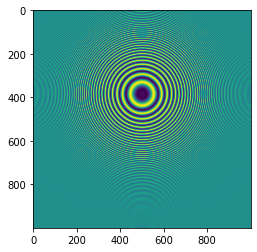

In [93]:
# single point
k = np.zeros((1000, 1000))
aaf = anti_f(pp*2, 0.3, wvl_R)
x0 = -0.001
y0 = 0
print(aaf)

for i in range(1000):
    for j in range(1000):
        x = (i - 500) * pp * 2
        y = (j - 500) * pp * 2
        if (x0-aaf < x < x0+aaf) and (y0 - aaf < y < y0 + aaf):
            k[i, j] = np.real(h_Fresnel(x0, y0, 0, x, y, 0.3, wvl_R))

plt.imshow(k)

0  th step finished
1  th step finished
2  th step finished
3  th step finished
4  th step finished
5  th step finished
6  th step finished
7  th step finished
8  th step finished
9  th step finished
10  th step finished
11  th step finished
12  th step finished
13  th step finished
14  th step finished
15  th step finished
16  th step finished
17  th step finished
18  th step finished
19  th step finished


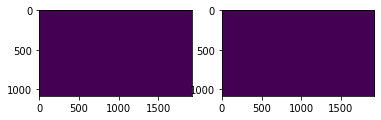

In [88]:
fh_r, fh_i = Fresnel_hologen(0.05, wvl_R)

plt.subplot(121)
plt.imshow(fh_r)

plt.subplot(122)
plt.imshow(fh_i)


# Reconstruction image with ASM

angular spectrum methods를 사용하여 이미지를 다시 복원하는 과정

In [119]:
# Reconst image with ASM
res = h / 2
def asm_kernel(Reconst_z):
    """
    Angular spectrum kernel to reconst picture
    """
    kernal = np.zeros((h , h)) 
    asm = -2j * np.pi * Reconst_z
    for i in np.arange(h):
        for j in np.arange(h):
            x = i - h/2
            y = j - h/2
            c = (-pp * res / 2 + pp / 2) + x * pp
            r = (-pp * res / 2 + pp / 2) + y * pp
            squrt = wvl_R ** -2 - ((r / pp - 0.5) / pp / res) ** 2 - ((c / pp - 0.5) / pp / res) ** 2
            kernal[i,j] = np.exp(asm * np.sqrt(squrt))
    return kernal

def Reconst(z, ch):
    """
    Reconstruct hologram at z mm
    """
    p = asm_kernel(z)
    A = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(ch)))
    img = p * A
    img = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(img)))
    img = img * np.conj(img)
    img = img / np.max(img)
    #img to uint8
    return img

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


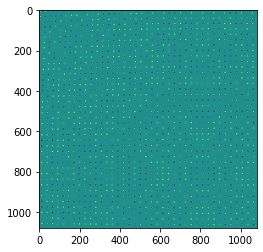

In [121]:
plt.imshow(np.real(asm_kernel(0.3)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


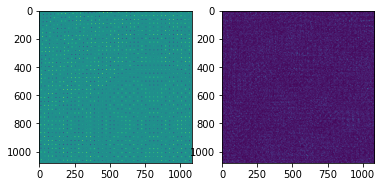

In [122]:
# reconst image
CH = rs_r + 1j*rs_i

reconst = Reconst(0.3, CH[:,420:1500])

plt.subplot(121)
plt.imshow(asm_kernel(0.3))

plt.subplot(122)
plt.imshow(np.abs(reconst))